# Modelo de predicción

In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

1. Leer los datos procesados

In [17]:
df = pd.read_csv('../data/consumption_features.csv')
df.head()

,Flight_ID,Date,Passenger_Count,Product_Name,Unit_Cost,Crew_Feedback,haul,Origin_DOH,Origin_JFK,Origin_LHR,...,Product_CHO050,Product_COF200,Product_CRK075,Product_DRK023,Product_DRK024,Product_HTB110,Product_JCE200,Product_NUT030,Product_SNK001,Percentage_Returned
0,LX110,2025-09-26,272,Bread Roll Pack,0.35,NaN,2,True,False,False,...,False,False,False,False,False,False,False,False,False,0.327684
1,LX110,2025-09-26,272,Chocolate Bar 50g,0.80,NaN,2,True,False,False,...,True,False,False,False,False,False,False,False,False,0.326531
2,LX110,2025-09-26,272,Butter Cookies 75g,0.75,drawer incomplete,2,True,False,False,...,False,False,True,False,False,False,False,False,False,0.274809
3,LX110,2025-09-26,272,Sparkling Water 330ml,0.45,NaN,2,True,False,False,...,False,False,False,True,False,False,False,False,False,0.180488
4,LX110,2025-09-26,272,Still Water 500ml,0.50,NaN,2,True,False,False,...,False,False,False,False,True,False,False,False,False,0.482234


## Preparación del dataset

1. Preparación de los datos

In [18]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# --- 1. Manejo de Fechas ---
# Convertimos la columna 'Date' a tipo datetime
df['Date'] = pd.to_datetime(df['Date'])
# Extraemos features numéricas de la fecha
df['Month'] = df['Date'].dt.month
df['DayOfWeek'] = df['Date'].dt.dayofweek

# --- 2. Definición de X e Y ---
TARGET_COLUMN = 'Percentage_Returned'

# Y es nuestra columna objetivo
Y = df[TARGET_COLUMN]

# X son todas las demás columnas
X = df.drop(TARGET_COLUMN, axis=1)

# --- 3. Eliminación de Columnas No Útiles ---
# Eliminamos columnas que no son numéricas o son redundantes/díficiles de procesar
# (Product_Name ya está en formato One-Hot con 'Product_...')
# (Crew_Feedback tiene texto y NaNs, para este modelo lo omitiremos)
COLUMNS_TO_DROP = ['Flight_ID', 'Date', 'Product_Name', 'Crew_Feedback']
X = X.drop(columns=COLUMNS_TO_DROP)

# Llenamos cualquier posible NaN restante en X (si lo hubiera) con 0
X = X.fillna(0)

# --- 4. División de Datos (90% train, 10% test) ---
# Usamos test_size=0.10 para obtener un 10% de datos de prueba
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.10, random_state=42)

print(f"Forma de X_train: {X_train.shape}")
print(f"Forma de X_test: {X_test.shape}")
print(f"Forma de Y_train: {Y_train.shape}")
print(f"Forma de Y_test: {Y_test.shape}")

# --- 5. Escalamiento de Datos ---
# Es crucial para las redes neuronales que los datos estén en una escala similar
scaler = StandardScaler()

# Ajustamos el scaler SÓLO con los datos de entrenamiento (para evitar data leakage)
X_train_scaled = scaler.fit_transform(X_train)

# Transformamos los datos de prueba con el scaler ya ajustado
X_test_scaled = scaler.transform(X_test)

Forma de X_train: (420, 21)
Forma de X_test: (47, 21)
Forma de Y_train: (420,)
Forma de Y_test: (47,)


## Modelos y Parámetros

In [22]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score

# 1. Definimos el modelo de Random Forest
# n_estimators = el número de "árboles" en el bosque. 100 es un buen punto de partida.
# random_state=42 asegura que obtengas los mismos resultados cada vez que lo corras.
rf_model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)

## Entrenamiento del modelo

In [23]:
print("Iniciando entrenamiento del Random Forest...")

# 2. Entrenamos el modelo
# ¡Nota que usamos X_train y no X_train_scaled!
rf_model.fit(X_train, Y_train)

print("Entrenamiento finalizado.")

Iniciando entrenamiento del Random Forest...
Entrenamiento finalizado.



--- 1. Iniciando la predicción en el conjunto de prueba... ---

--- 2. Métricas de Evaluación (Random Forest) ---
Error Absoluto Medio (MAE) en Test: 0.0948
R-cuadrado (R²) en Test: -0.3081

(El MAE significa que, en promedio, las predicciones se equivocan por ~9.48 puntos porcentuales.)

Comparación R²:
  Random Forest: -0.3081
  Red Neuronal:  -0.9235 (Valor anterior)

El R² sigue siendo negativo o cero. El modelo aún no logra generalizar.

--- 3. Comparación Directa (Predicción vs. Real) ---
    Actual_Returned  Predicted_Returned  Difference (Error)
0          0.178744            0.275758           -0.097014
1          0.148810            0.328793           -0.179983
2          0.211921            0.345163           -0.133243
3          0.392000            0.285660            0.106340
4          0.387597            0.278682            0.108915
5          0.151515            0.324319           -0.172804
6          0.203540            0.322633           -0.119093
7          0.194631

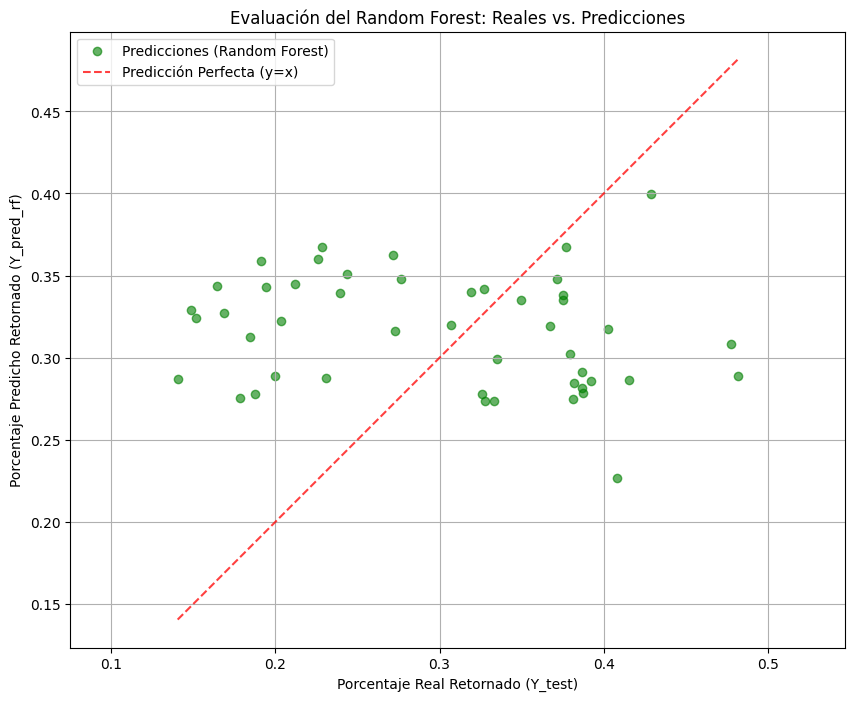

In [24]:
print("\n--- 1. Iniciando la predicción en el conjunto de prueba... ---")

# 1. Obtenemos las predicciones del modelo
# ¡Nota que usamos X_test y no X_test_scaled!
Y_pred_rf = rf_model.predict(X_test)

print("\n--- 2. Métricas de Evaluación (Random Forest) ---")

# 2. Calculamos las métricas
rf_mae = mean_absolute_error(Y_test, Y_pred_rf)
rf_r2 = r2_score(Y_test, Y_pred_rf)

print(f"Error Absoluto Medio (MAE) en Test: {rf_mae:.4f}")
print(f"R-cuadrado (R²) en Test: {rf_r2:.4f}")

print(f"\n(El MAE significa que, en promedio, las predicciones se equivocan por ~{rf_mae*100:.2f} puntos porcentuales.)")

# Comparamos con el R² de tu Red Neuronal
print(f"\nComparación R²:")
print(f"  Random Forest: {rf_r2:.4f}")
print(f"  Red Neuronal:  -0.9235 (Valor anterior)")

if rf_r2 > 0:
    print("\n¡Excelente! Un R² positivo significa que el modelo es mucho mejor que antes.")
else:
    print("\nEl R² sigue siendo negativo o cero. El modelo aún no logra generalizar.")
    
    
# --- 3. Comparación Directa (DataFrame) ---
print("\n--- 3. Comparación Directa (Predicción vs. Real) ---")
df_comparison_rf = pd.DataFrame({
    'Actual_Returned': Y_test.reset_index(drop=True),
    'Predicted_Returned': Y_pred_rf
})
df_comparison_rf['Difference (Error)'] = df_comparison_rf['Actual_Returned'] - df_comparison_rf['Predicted_Returned']
print(df_comparison_rf.head(20))


# --- 4. Evaluación Visual (Scatter Plot) ---
print("\n--- 4. Generando Gráfico de Evaluación (Random Forest)... ---")

plt.figure(figsize=(10, 8))
plt.scatter(Y_test, Y_pred_rf, alpha=0.6, label='Predicciones (Random Forest)', color='green')

# Línea de 45 grados (Predicción Perfecta)
lims = [
    min(Y_test.min(), Y_pred_rf.min()),
    max(Y_test.max(), Y_pred_rf.max())
]
plt.plot(lims, lims, 'r--', alpha=0.75, label='Predicción Perfecta (y=x)')

plt.xlabel('Porcentaje Real Retornado (Y_test)')
plt.ylabel('Porcentaje Predicho Retornado (Y_pred_rf)')
plt.title('Evaluación del Random Forest: Reales vs. Predicciones')
plt.legend()
plt.grid(True)
plt.axis('equal')
plt.show()